In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms.functional as F

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Data

In [8]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Data preprocessing and augmentation
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])


train_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Training', transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ImageFolder('/kaggle/input/brain-tumor-mri-dataset/Testing', transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [9]:
print(train_dataset)
print(train_dataset.classes)

Dataset ImageFolder
    Number of datapoints: 5712
    Root location: /kaggle/input/brain-tumor-mri-dataset/Training
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )
['glioma', 'meningioma', 'notumor', 'pituitary']


In [23]:
def denormalize(images):
    images = images.numpy().transpose(0, 2, 3, 1) # from (batch, channels, height, width) -> (batch, height, width, channels), for visiualisation    
    images = images*std + mean # denormalise
    images = images.clip(0,1) # for visualization
    return images

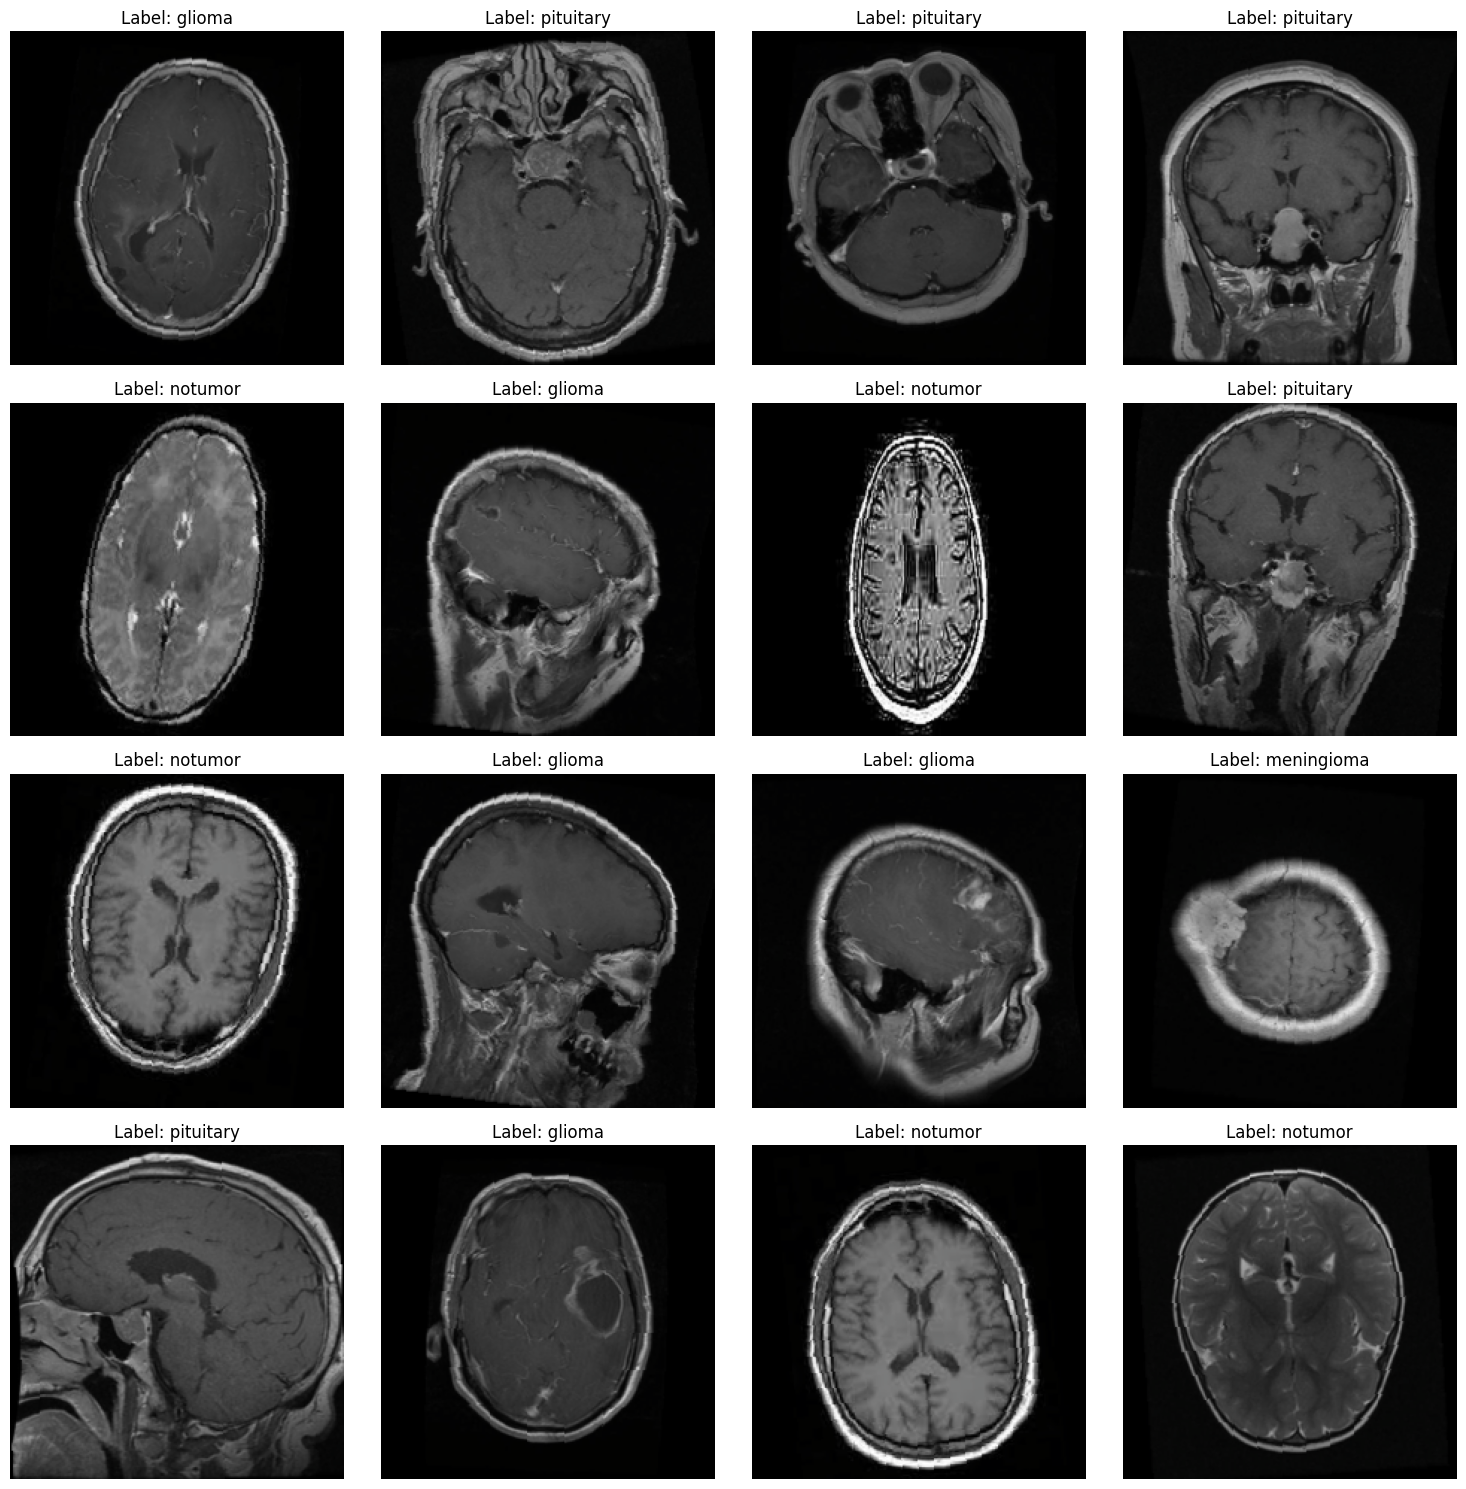

In [24]:
# Visualize a batch of images and labels 
data_iter = iter(train_loader)
images, labels = next(data_iter)

images = denormalize(images)

# Create a grid of images
num_images = len(images)
rows = int(np.ceil(num_images / 4))

fig, axes = plt.subplots(rows, 4, figsize=(15, 15))

# Plot images with labels
for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {train_dataset.classes[labels[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Model Architecture

In [25]:
class TumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(TumorClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)  # Cross Entropy Loss internally applies softmax to logit = x (for binary use sigmoid, BCE loss)
        return x

model = TumorClassifier(num_classes=4)
model.to(device)

TumorClassifier(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=100352, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [26]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model Training

In [27]:
# Training loop
num_epochs = 20
best_val_accuracy = 0.0
patience = 5
epochs_without_improvement = 0

# Initialize lists to store training history
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    train_pbar = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Training')
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        train_pbar.set_postfix({'Loss': train_loss / (train_pbar.n + 1), 'Accuracy': correct / total})
    
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f'Epoch [{epoch+1}/{num_epochs}] Validation')
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            val_pbar.set_postfix({'Loss': val_loss / (val_pbar.n + 1), 'Accuracy': correct / total})
            
    val_loss /= len(val_loader)
    val_accuracy = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2%}')
    
    # Save the best model and check for early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    # Early stopping
    if epochs_without_improvement >= patience:
        torch.save(model.state_dict(), 'classifier.pth')
        print(f'Early stopping triggered after {epoch+1} epochs')
        break

Epoch [1/20] Validation: 100%|██████████| 82/82 [00:12<00:00,  6.56it/s, Loss=0.477, Accuracy=0.831]


Epoch [1/20], Training Loss: 221.3616, Training Accuracy: 77.61%, Validation Loss: 0.4772, Validation Accuracy: 83.07%


Epoch [2/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.76it/s, Loss=0.284, Accuracy=0.902]


Epoch [2/20], Training Loss: 115.8503, Training Accuracy: 88.04%, Validation Loss: 0.2810, Validation Accuracy: 90.16%


Epoch [3/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.64it/s, Loss=0.241, Accuracy=0.915]


Epoch [3/20], Training Loss: 77.8930, Training Accuracy: 91.72%, Validation Loss: 0.2385, Validation Accuracy: 91.46%


Epoch [4/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.86it/s, Loss=0.226, Accuracy=0.937] 


Epoch [4/20], Training Loss: 55.4587, Training Accuracy: 94.24%, Validation Loss: 0.2231, Validation Accuracy: 93.67%


Epoch [5/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.81it/s, Loss=0.169, Accuracy=0.949]


Epoch [5/20], Training Loss: 44.4128, Training Accuracy: 95.83%, Validation Loss: 0.1670, Validation Accuracy: 94.89%


Epoch [6/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.02it/s, Loss=0.15, Accuracy=0.955]  


Epoch [6/20], Training Loss: 32.8763, Training Accuracy: 97.18%, Validation Loss: 0.1480, Validation Accuracy: 95.50%


Epoch [7/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.84it/s, Loss=0.145, Accuracy=0.962]


Epoch [7/20], Training Loss: 27.7781, Training Accuracy: 97.48%, Validation Loss: 0.1433, Validation Accuracy: 96.19%


Epoch [8/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.50it/s, Loss=0.137, Accuracy=0.973] 


Epoch [8/20], Training Loss: 23.1772, Training Accuracy: 97.76%, Validation Loss: 0.1353, Validation Accuracy: 97.25%


Epoch [9/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 13.18it/s, Loss=0.221, Accuracy=0.953] 


Epoch [9/20], Training Loss: 19.1780, Training Accuracy: 98.07%, Validation Loss: 0.2186, Validation Accuracy: 95.27%


Epoch [10/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.87it/s, Loss=0.0986, Accuracy=0.97] 


Epoch [10/20], Training Loss: 23.4311, Training Accuracy: 97.93%, Validation Loss: 0.0974, Validation Accuracy: 97.03%


Epoch [11/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.96it/s, Loss=0.138, Accuracy=0.963] 


Epoch [11/20], Training Loss: 16.1172, Training Accuracy: 98.76%, Validation Loss: 0.1360, Validation Accuracy: 96.34%


Epoch [12/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.82it/s, Loss=0.135, Accuracy=0.965] 


Epoch [12/20], Training Loss: 17.9492, Training Accuracy: 98.35%, Validation Loss: 0.1338, Validation Accuracy: 96.49%


Epoch [13/20] Validation: 100%|██████████| 82/82 [00:06<00:00, 12.95it/s, Loss=0.145, Accuracy=0.966]


Epoch [13/20], Training Loss: 13.1642, Training Accuracy: 98.98%, Validation Loss: 0.1430, Validation Accuracy: 96.64%
Early stopping triggered after 13 epochs


<All keys matched successfully>

# Model Evaluation

In [32]:
# Load the best model
model.load_state_dict(torch.load('classifier.pth'))

<All keys matched successfully>

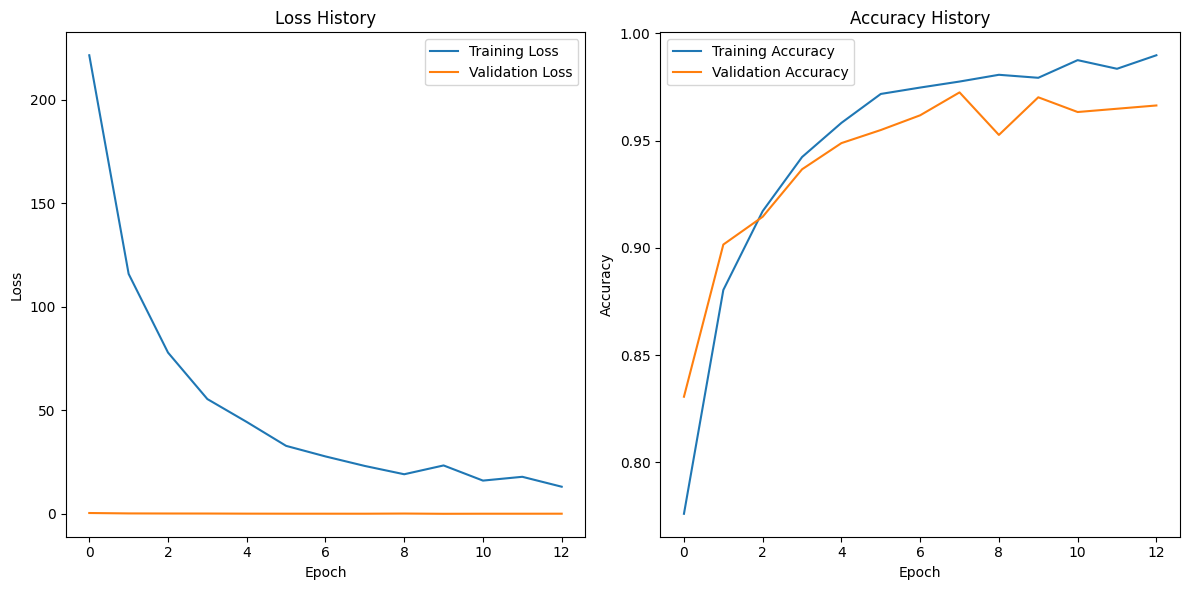

Validation Accuracy: 96.64%


In [33]:
# Visualize training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

accuracy = correct / total
print(f'Validation Accuracy: {accuracy:.2%}')

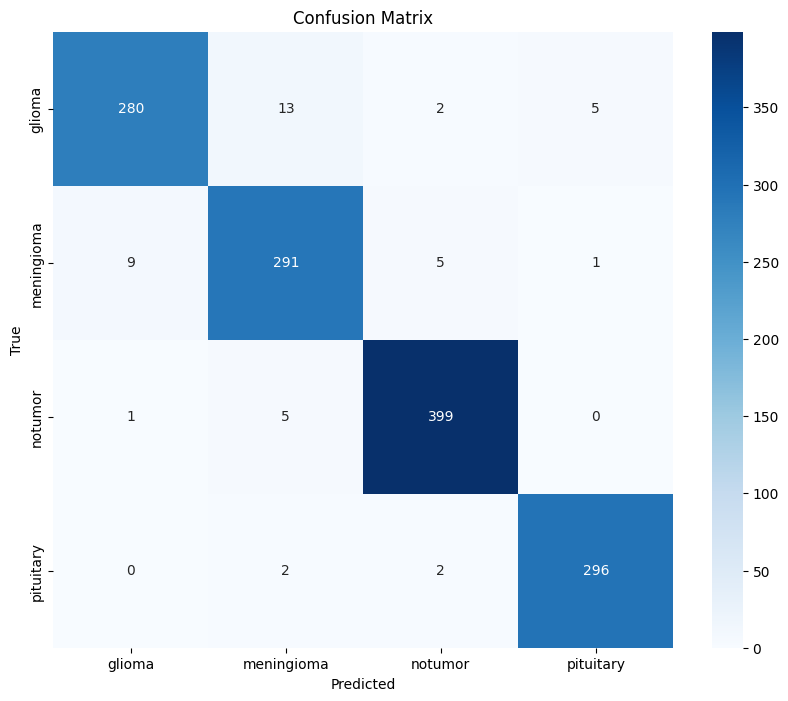

              precision    recall  f1-score   support

      glioma       0.97      0.93      0.95       300
  meningioma       0.94      0.95      0.94       306
     notumor       0.98      0.99      0.98       405
   pituitary       0.98      0.99      0.98       300

    accuracy                           0.97      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.97      0.97      0.97      1311

Accuracy: 96.5675%


In [35]:
model.eval()

all_labels = []
all_predictions = []

# Disable gradient calculation
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Get the predicted class
        _, predicted = torch.max(outputs, 1)
        
        # Append true labels and predictions to lists
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Get class names
class_names = val_dataset.classes

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Calculate and print classification report
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_predictions, target_names=class_names))

# Calculate and print overall accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Accuracy: {accuracy*100:.4f}%")